In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ot
import ot.plot
import time
import numpy.linalg as la
import networkx as nx
import math
#from pointcloud_utils import vox_to_pointcloud
#import pointcloud_utils
from sklearn import manifold as man
# NOTE: RBFInterpolator needs scipy>=1.7.0
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path
from scipy.interpolate import NearestNDInterpolator
from scipy.interpolate import LinearNDInterpolator
#from scipy.interpolate import RBFInterpolator

In [25]:
def load_fashion_mnist_from_csv(train_csv_path, test_csv_path):
    # Load training data
    train_df = pd.read_csv(train_csv_path)
    train_labels = train_df['label'].values
    train_pixels = train_df.drop('label', axis=1).values.reshape(-1, 28, 28)

    # Load test data
    test_df = pd.read_csv(test_csv_path)
    test_labels = test_df['label'].values
    test_pixels = test_df.drop('label', axis=1).values.reshape(-1, 28, 28)

    return (train_pixels, train_labels), (test_pixels, test_labels)


In [26]:
(train_images, train_labels), (test_images, test_labels) = load_fashion_mnist_from_csv('fashion-mnist_train.csv', 'fashion-mnist_test.csv')

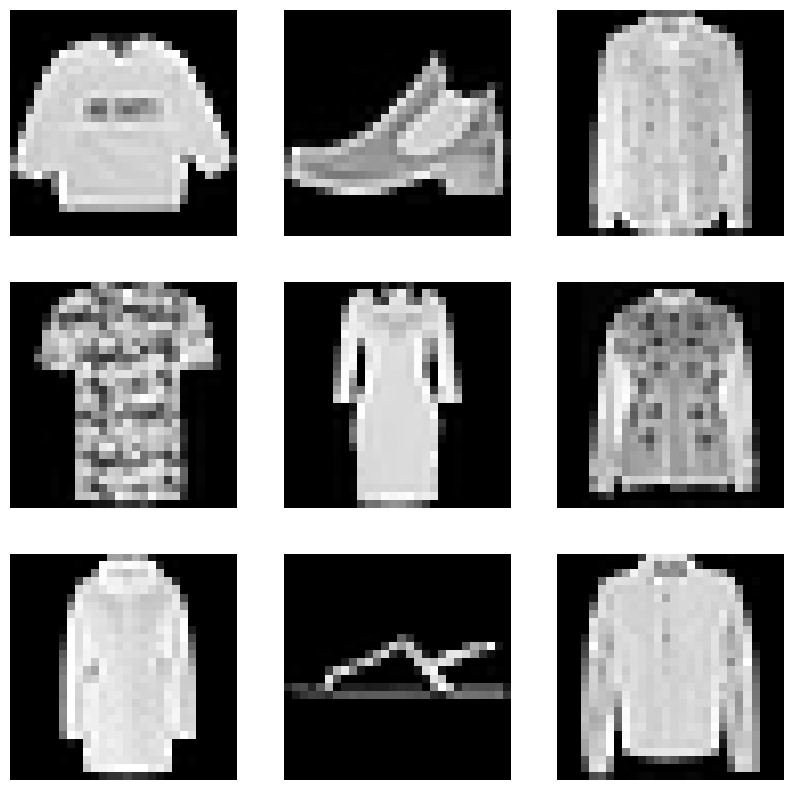

In [4]:
train_X = train_images#.drop("label", axis=1).values
train_y = train_labels#['label'].values

test_X = test_images

img_rows, img_cols = 28, 28

train_X = train_X.reshape(train_X.shape[0], img_rows, img_cols)
test_X = test_X.reshape(test_X.shape[0], img_rows, img_cols)

# Create subplots
fig, plts = plt.subplots(3, 3, figsize=(10, 10))
for i in range(3):
    for j in range(3):
        idx = i * 3 + j
        plts[i, j].imshow(train_X[idx], cmap=plt.get_cmap('gray'))
        plts[i, j].axis('off')  # Turn off axis
plt.show()

In [5]:
zeros = train_X[train_y==0]
zeros.shape

ones = train_X[train_y==1]

twos = train_X[train_y==2]

threes = train_X[train_y==3]

fours = train_X[train_y==4]

fives = train_X[train_y==5]
sixes = train_X[train_y==6]
sevens = train_X[train_y==7]
eights = train_X[train_y==8]
nines = train_X[train_y==9]

In [6]:
def vox_to_pointcloud(voxarray,grid,eps=0):
    xx,yy = np.squeeze(np.split(grid,2))
    X = np.vstack((xx.ravel(),yy.ravel())).T
    nX  = X.shape[0] # Number of points = number of rows
    nvi = voxarray.shape[0] # Number of voxel rows
    nvj = voxarray.shape[1] # Number of voxel cols
    if nX != nvi*nvj: raise ValueError("Number of grid points must equal number of voxels!")
    X = np.concatenate((X,voxarray.T.reshape(nvi*nvj,1)),axis=1)
    return X[X[:,2]>eps,:]

In [7]:
def pointcloud_to_vox(array,grid):
    # Converts a pointcloud representation to a voxel representation
    # Assumes that the grid is in "ij meshgrid" format i.e. grid has two layers, xx and yy; each are size (nx+1)-by-(ny+1)
    # The grid points are assumed to define the corners of the voxels, so the
    # voxel rep will be a single nx-by-ny array with entries equal to the average pointcloud weights
    # V_ij = \mean_k W_k if (x_k,y_k) is in voxel ij
    xx,yy = np.squeeze(np.split(grid,2))

    points = array[:,0:2]
    values = array[:,2]
#   interp = NearestNDInterpolator(points,values)
    interp = LinearNDInterpolator(points,values,fill_value=0.0)
    X = interp(xx,yy).T
    #interp = RBFInterpolator(points,values,smoothing=0,kernel='linear')
    #X = np.reshape(interp(np.vstack((xx.ravel(),yy.ravel())).T),(xx.shape[0],xx.shape[1]))
    return X

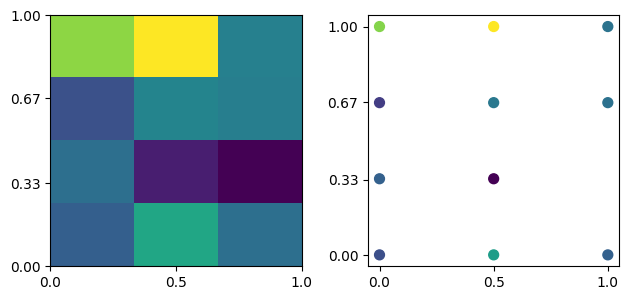

In [8]:
# Testing voxel-to-pointcloud conversion

# First, create voxel array
numx = 3
numy = 4

voxarray = np.random.rand(numy,numx)  # Note: number of rows = number of y points
# Set one of the elements to zero (to check zero weight handling)
voxarray[1,2] = 0

# Create a pointcloud grid for vox-to-PC conversion
nxg = numx
nyg = numy
x = np.linspace(0,1,nxg)
y = np.linspace(0,1,nyg)
xx,yy = np.meshgrid(x,y,indexing='ij')
grid = np.stack((xx,yy))
# Convert voxel array to pointcloud
X = vox_to_pointcloud(voxarray,grid)
# Plot voxel array and its pointcloud rep
fig1,(ax1,ax2) = plt.subplots(1,2)

ax1.imshow(voxarray,origin='lower',extent=(0,1,0,1))
ax1.set_xticks(np.round(x,2))
ax1.set_yticks(np.round(y,2))
ax2.scatter(X[:,0],X[:,1],s=50,c=X[:,2])

ax2.set_aspect(1)
ax2.set_xticks(np.round(x,2))
ax2.set_yticks(np.round(y,2))
fig1.tight_layout()

(0.0, 1.0)

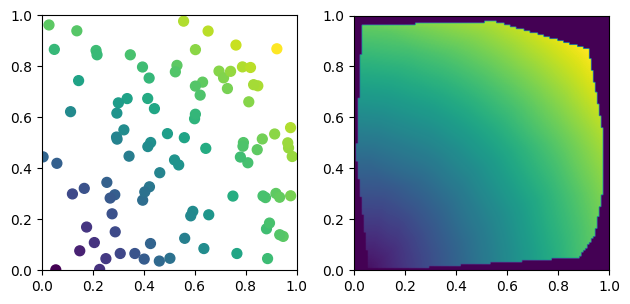

In [9]:
# Testing pointcloud-to-voxel conversion

# Generate a pointcloud by selecting random points
nPC = 100
points = np.random.rand(nPC,2)
values = np.hypot(points[:,0],points[:,1])
PCarray = np.hstack((points,values[:,np.newaxis]))
# Create a grid for pointcloud-to-voxel conversion
nxg = 129
nyg = 129
x = np.linspace(0,1,nxg)
y = np.linspace(0,1,nyg)
xx,yy = np.meshgrid(x,y,indexing='ij')
grid = np.stack((xx,yy))
Y = pointcloud_to_vox(PCarray,grid)

fig2,(ax3,ax4) = plt.subplots(1,2)
fig2.tight_layout()
ax3.scatter(PCarray[:,0],PCarray[:,1],s=50,c=PCarray[:,2])
ax4.imshow(Y,origin='lower',extent=[0,1,0,1])
ax3.set_aspect(1)
ax3.set_xlim(0,1)
ax3.set_ylim(0,1)

In [10]:
# Testing meshgrid, stack and split ops
nxg = 3
nyg = 4
x = np.linspace(0,1,nxg)
y = np.linspace(0,1,nyg)
xx,yy = np.meshgrid(x,y,indexing='ij')
grid = np.stack((xx,yy))
xx2,yy2 = np.squeeze(np.split(grid,2))
#
display(xx)
display(yy)
display(grid)
display(xx2)
display(yy2)

array([[0. , 0. , 0. , 0. ],
       [0.5, 0.5, 0.5, 0.5],
       [1. , 1. , 1. , 1. ]])

array([[0.        , 0.33333333, 0.66666667, 1.        ],
       [0.        , 0.33333333, 0.66666667, 1.        ],
       [0.        , 0.33333333, 0.66666667, 1.        ]])

array([[[0.        , 0.        , 0.        , 0.        ],
        [0.5       , 0.5       , 0.5       , 0.5       ],
        [1.        , 1.        , 1.        , 1.        ]],

       [[0.        , 0.33333333, 0.66666667, 1.        ],
        [0.        , 0.33333333, 0.66666667, 1.        ],
        [0.        , 0.33333333, 0.66666667, 1.        ]]])

array([[0. , 0. , 0. , 0. ],
       [0.5, 0.5, 0.5, 0.5],
       [1. , 1. , 1. , 1. ]])

array([[0.        , 0.33333333, 0.66666667, 1.        ],
       [0.        , 0.33333333, 0.66666667, 1.        ],
       [0.        , 0.33333333, 0.66666667, 1.        ]])

grid shape (2, 28, 28)


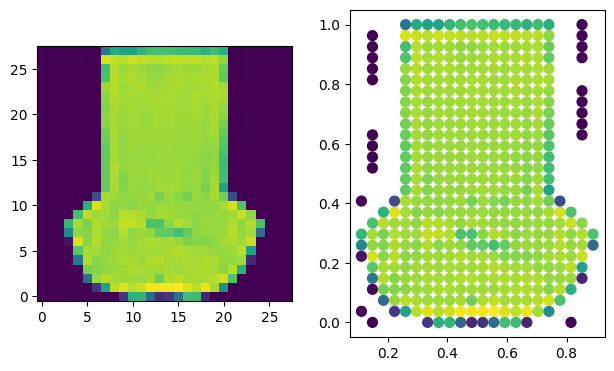

In [11]:
nxg = 28
nyg = 28
x = np.linspace(0,1,nxg)
y = np.linspace(0,1,nyg)
xx, yy = np.meshgrid(x,y,indexing='ij')
grid = np.stack((xx,yy))

print("grid shape",grid.shape)

voxarray = zeros[1,:,:]  
X = vox_to_pointcloud(voxarray,grid)

# Plot voxel array and its pointcloud rep
fig1,(ax1,ax2) = plt.subplots(1,2)
fig1.tight_layout()
ax1.imshow(voxarray,origin='lower')
ax2.scatter(X[:,0],X[:,1],s=50,c=X[:,2])

ax2.set_aspect(1)

grid shape (2, 28, 28)


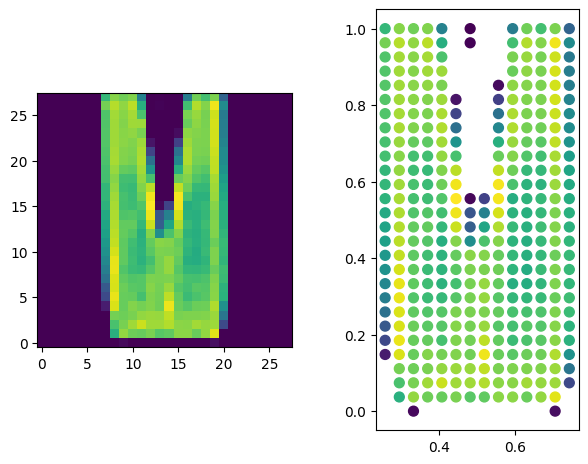

In [12]:
nxg = 28
nyg = 28
x = np.linspace(0,1,nxg)
y = np.linspace(0,1,nyg)
xx, yy = np.meshgrid(x,y,indexing='ij')
grid = np.stack((xx,yy))

print("grid shape",grid.shape)

voxarray = ones[1,:,:]  
X = vox_to_pointcloud(voxarray,grid)

# Plot voxel array and its pointcloud rep
fig1,(ax1,ax2) = plt.subplots(1,2)
fig1.tight_layout()
ax1.imshow(voxarray,origin='lower')
ax2.scatter(X[:,0],X[:,1],s=50,c=X[:,2])

ax2.set_aspect(1)

In [13]:
num_samples = 300
idx = np.random.choice(train_images.shape[0], num_samples, replace=False)
subset_train = train_images[idx]
subset_train_labels = train_labels[idx]

In [14]:
# Applying the pointcloud to the subset_train
grid_x, grid_y = np.meshgrid(np.arange(28), np.arange(28))
grid = np.stack((grid_x, grid_y))

# Reshape subset_train images back to 28x28
reshaped_images = subset_train.reshape(-1, 28, 28)

# Initialize a list to store the point clouds
pointclouds = []

# Convert each image in the subset to a point cloud
for image in reshaped_images:
    pointcloud = vox_to_pointcloud(image, grid)
    pointclouds.append(pointcloud)

### Embeddings

In [15]:
def uniform_Wass_squared(U, V,Itermax=100000):
    # Assumes that U and V are pointclouds i.e. U = [x1,y1,w1;...;xp,yp,wp] etc
    Upts = np.ascontiguousarray(U[:,0:2])
    Vpts = np.ascontiguousarray(V[:,0:2])
    Uwts = np.ascontiguousarray(U[:,2])
    Vwts = np.ascontiguousarray(V[:,2])
    Uwts = Uwts/np.sum(Uwts)
    Vwts = Vwts/np.sum(Vwts)
    M = ot.dist(Upts, Vpts)  # Compute euclidean distance on the pointcloud points
    W = ot.emd2(Uwts,Vwts, M,numItermax=Itermax)
    return W

def Wasserstein_Matrix(image_list,squared=True):
    """
    The function compute the (squared if squared=True) Wasserstein Distance Matrix between N images
    image_list: python list of pointcloud representations
    """
    N = len(image_list) #number of images
    distance = np.zeros((N,N)) #initialize the distance matrix

    #cost = ot.dist(supp, supp) #should be a MXM array
    for i in range(N):
        for j in range(i+1,N):
            if squared==True:
                distance[i,j] = uniform_Wass_squared(image_list[i], image_list[j])
            else:
                distance[i,j] = uniform_Wass_squared(image_list[i], image_list[j])**.5
    distance += distance.T
    return distance

def Euclidean_Matrix(image_tensor,squared=True):
    """
    The function compute the (squared if squared=True) Euclidean Distance Matrix between N 2D images
    image_tensor: Should be a Mx2xN array, where M is the number of pixels.
    """
    N = image_tensor.shape[-1] #number of rows
    distance = np.zeros((N,N)) #initialize the distance matrix
    for i in range(N):
        for j in range(i+1,N):
            if squared==True:
                distance[i,j] = la.norm(image_tensor[:,:,i]-image_tensor[:,:,j])**2
            else:
                distance[i,j] = la.norm(image_tensor[:,:,i]-image_tensor[:,:,j])
    distance += distance.T
    return distance

def Geodesic_Matrix(image_tensor,eps,squared=True):
    """
    Computes the Geodesic distance matrix for a set of N images
    image_tensor is Mx2xN
    """
    Euc_distance = Euclidean_Matrix(image_tensor,squared=False)
    Adj_matrix = np.copy(Euc_distance)
    Adj_matrix[Adj_matrix<eps] = 0
    Euc_distance[Euc_distance<eps] = np.Inf
    G = nx.from_numpy_array(Adj_matrix)
    geo_matrix = shortest_path(Euc_distance, directed=False, return_predecessors=False)
    if(squared==True):
        geo_matrix = np.square(geo_matrix)
    return geo_matrix,G

def MDS(distance_matrix, num_components=2, squared=False):
    """
    Computes non-metric (classical) Multidimensional Scaling (MDS)
    Input should be an NxN distance matrix
    The Boolean squared indicates if the distance matrix passed to the function has already
    been squared entrywise (True) or not (False)
    """
    N = distance_matrix.shape[0]
    H = np.eye(N)-1/N*np.ones((N,N))
    if squared==False:
        B = -.5*H@(distance_matrix**2)@H
    else:
        B = -.5*H@distance_matrix@H
    U,S,VT = la.svd(B)
    embedding = U[:,:num_components]@np.diag(S[:num_components]**.5)
    return embedding

In [16]:
Wass_distance = Wasserstein_Matrix(pointclouds, squared=True)

In [17]:
WassEmbedding = MDS(Wass_distance, num_components=2, squared=True)

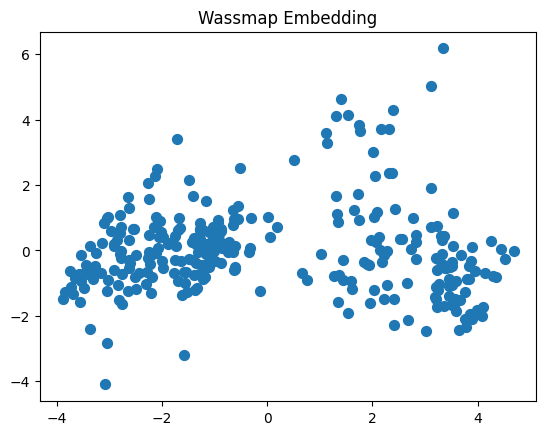

In [18]:
fig, ax1 = plt.subplots()
scatter_x = WassEmbedding[:, 0]
scatter_y = WassEmbedding[:, 1]
ax1.scatter(scatter_x, scatter_y, s=50)
ax1.set_title('Wassmap Embedding')
plt.show()

Text(0.5, 1.0, 'Wassmap Embedding')

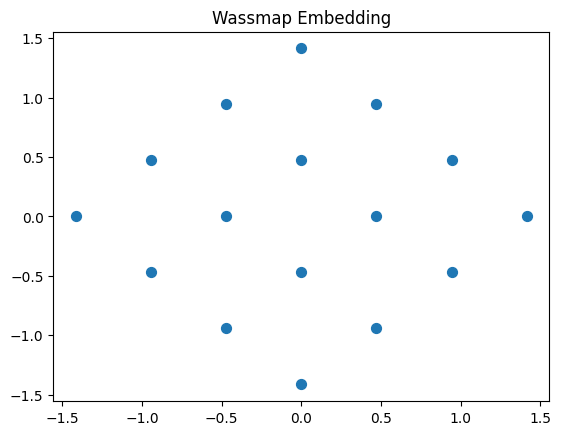

In [26]:
'''
WassEmbedding_trans = MDS(Wass_distance_trans,squared=True)
fig, ax1 = plt.subplots()
scatter_x = WassEmbedding_trans[:,0]
scatter_y = WassEmbedding_trans[:,1]
ax1.scatter(scatter_x,scatter_y,s=50)
#ax1.set_xlim([-8,9.5])
#ax1.set_ylim([-8,9.5])
ax1.set_title('Wassmap Embedding')

In [37]:
nvox = 128
nxg = nvox
nyg = nvox
num_dilates = 4
grid_x, grid_y = np.meshgrid(np.arange(28), np.arange(28))
grid = np.stack((grid_x, grid_y))
dil_images_vox = np.zeros((nvox,nvox,num_dilates**2))

voxel_list = [pointcloud_to_vox(pc, grid) for pc in pointclouds]

In [33]:
image_tensor = np.stack(voxel_list, axis=-1)  # Stacks along the third dimension

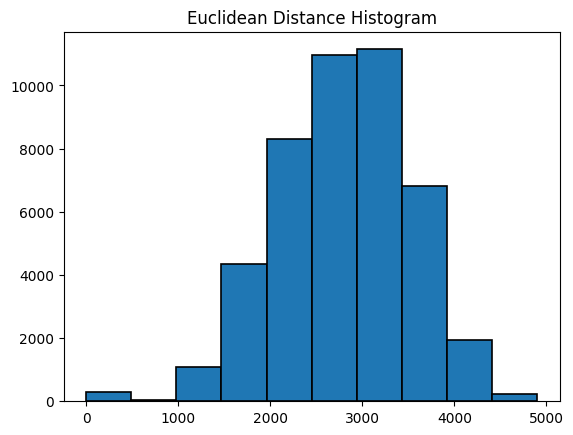

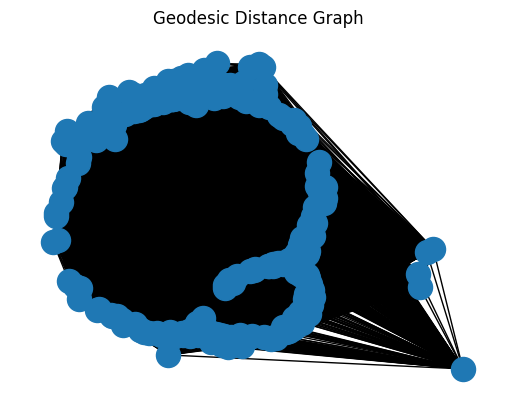

In [21]:
# Compute the Euclidean Distance Matrix
euc_matrix = Euclidean_Matrix(image_tensor, squared=False)

# Plot histogram of the Euclidean distances
fig, ax1 = plt.subplots()
num_translates = image_tensor.shape[-1]  # Assuming this represents the number of images
plt.hist(euc_matrix[np.triu_indices(num_translates)], edgecolor='black', linewidth=1.2)
plt.title("Euclidean Distance Histogram")
plt.show()

eps = 0.02


geo_distance, geo_graph = Geodesic_Matrix(image_tensor, eps, squared=True)

# Plot the graph
fig, ax2 = plt.subplots()
nx.draw(geo_graph, ax=ax2, pos=nx.spring_layout(geo_graph))
plt.title("Geodesic Distance Graph")
plt.show()


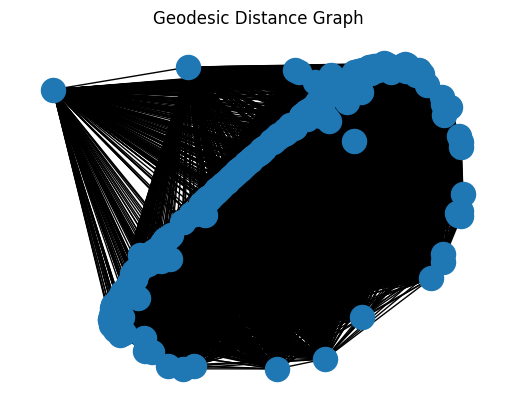

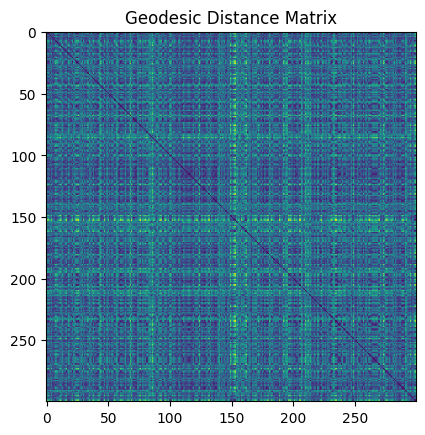

In [27]:
eps = 0.07  

# Compute the Geodesic Distance Matrix and the corresponding graph
geo_distance_trans, geo_graph_trans = Geodesic_Matrix(image_tensor, eps, squared=True)

# Plot the Geodesic graph
fig, ax2 = plt.subplots()
nx.draw(geo_graph_trans, ax=ax2, pos=nx.spring_layout(geo_graph_trans))
plt.title("Geodesic Distance Graph")
plt.show()

# Visualize the Geodesic Distance Matrix
fig, ax3 = plt.subplots()
ax3.imshow(geo_distance_trans)
plt.title("Geodesic Distance Matrix")
plt.show()

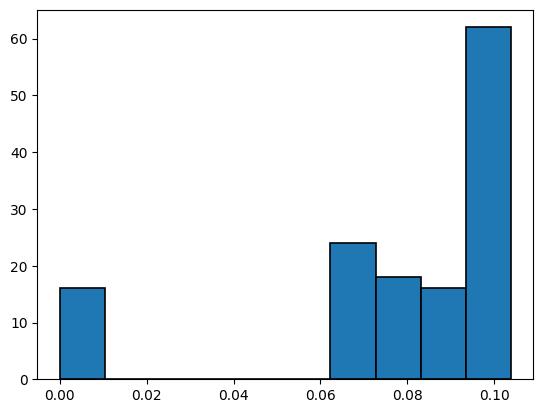

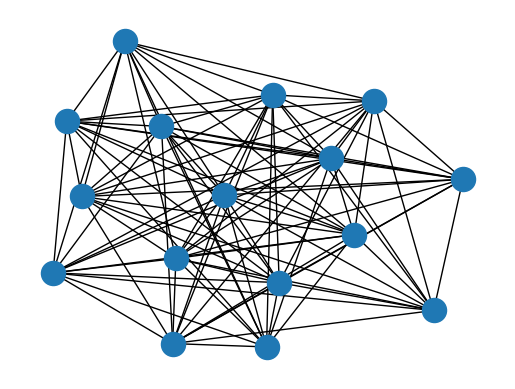

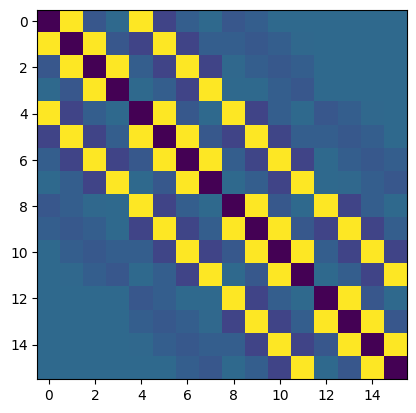

In [34]:
'''
## Circle translation test :: compute Euclidean distance matrix and select threshold
# Use the histogram to select the threshold.  Note that we want the un-squared matrix to select the threshold!
euc_matrix_trans = Euclidean_Matrix(trans_images_vox,squared=False)
#print(euc_matrix)
fig,ax1 = plt.subplots()
plt.hist(euc_matrix_trans[np.triu_indices(num_translates**2)],edgecolor='black', linewidth=1.2)
eps = .07
#eps = .025
# NOTE: if eps is too large, the graph will be disconnected and the distance matrix will have infs.
# GENERAL STRATEGY: Pick eps to be the largest value such that the graph remains connected
# You can use the distance histogram to pick this manually
geo_distance_trans,geo_graph_trans = Geodesic_Matrix(trans_images_vox,eps,squared = True)
# print('Graph weight matrix:')
# print(nx.adjacency_matrix(geo_graph).todense())
# print('Geodesic Distance Matrix:')
# print(geo_distance)
# print([n for n in geo_graph.neighbors(1)])
fig, ax2 = plt.subplots()
#nx.draw(geo_graph,ax=ax2,pos=nx.kamada_kawai_layout(geo_graph))
nx.draw(geo_graph_trans,ax=ax2,pos=nx.spring_layout(geo_graph_trans))

fig,ax3 = plt.subplots()
ax3.imshow(geo_distance_trans)

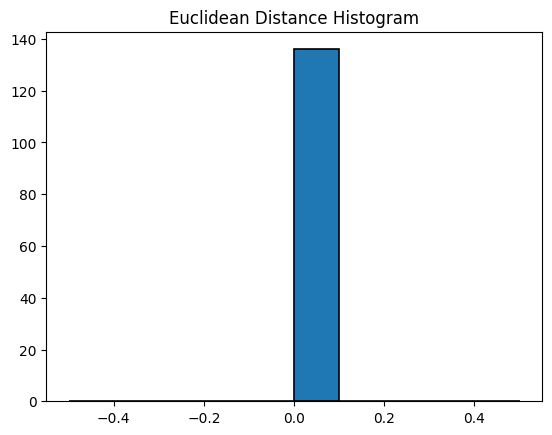

In [41]:
# Compute the Euclidean Distance Matrix
euc_matrix = Euclidean_Matrix(dil_images_vox, squared=False)

# Plot histogram of the Euclidean distances
fig, ax1 = plt.subplots()
num_dilates = dil_images_vox.shape[-1]  # The correct number of dilated images
plt.hist(euc_matrix[np.triu_indices(num_dilates)], edgecolor='black', linewidth=1.2)
plt.title("Euclidean Distance Histogram")
plt.show()

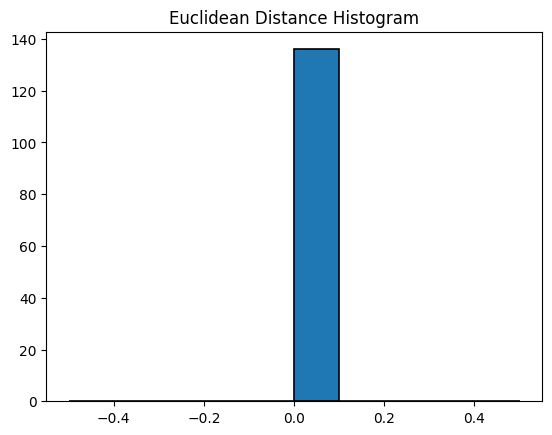

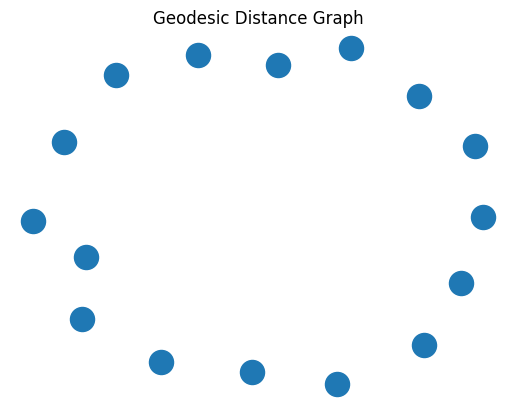

In [42]:
# Compute the Euclidean Distance Matrix
euc_matrix = Euclidean_Matrix(dil_images_vox, squared=False)

# Plot histogram of the Euclidean distances
fig, ax1 = plt.subplots()
plt.hist(euc_matrix[np.triu_indices(num_dilates)], edgecolor='black', linewidth=1.2)
plt.title("Euclidean Distance Histogram")
plt.show()

# Choose an appropriate value for eps based on the histogram
eps = 0.118  # Adjust this value based on your histogram

# Compute the Geodesic Distance Matrix and the corresponding graph
geo_distance, geo_graph = Geodesic_Matrix(dil_images_vox, eps, squared=True)

# Plot the Geodesic graph
fig, ax2 = plt.subplots()
nx.draw(geo_graph, ax=ax2, pos=nx.spring_layout(geo_graph))
plt.title("Geodesic Distance Graph")
plt.show()

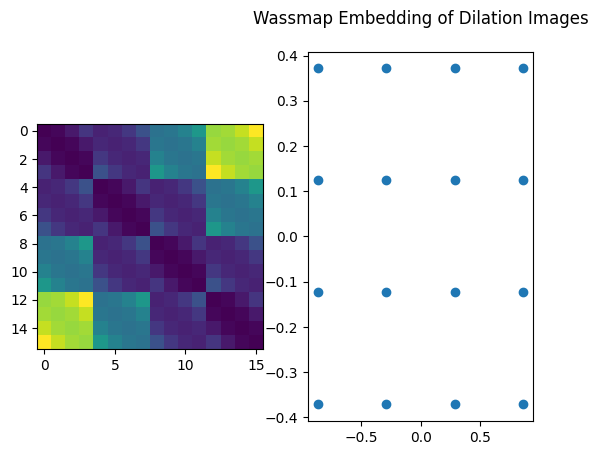

In [36]:
'''
# Compute Wasserstein square distance matrix
squared = True
Wass_distance = Wasserstein_Matrix(dil_images,squared=squared)

# Compute and display Wassmap embedding
#WassEmbedding = man.MDS(n_components=2,metric=True,dissimilarity='precomputed',eps=1e-4).fit_transform(Wass_distance)
WassEmbedding = MDS(Wass_distance,squared=squared)
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.imshow(Wass_distance)
ax2.set_title("Wassmap Embedding of Dilation Images",pad=20)
ax2.scatter(WassEmbedding[:,0],WassEmbedding[:,1])
#plt.savefig('figures/DilationWassmapEmbedding.pdf')
plt.show()

/var/folders/2x/m3nyg7x50mzg_7wsnzcm7hxr0000gn/T/ipykernel_80421/1784630450.py:7: RuntimeWarning: invalid value encountered in divide
  Uwts = Uwts/np.sum(Uwts)
/var/folders/2x/m3nyg7x50mzg_7wsnzcm7hxr0000gn/T/ipykernel_80421/1784630450.py:8: RuntimeWarning: invalid value encountered in divide
  Vwts = Vwts/np.sum(Vwts)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ot/lp/__init__.py:571: UserWarning: Problem infeasible. Check that a and b are in the simplex
  check_result(result_code)


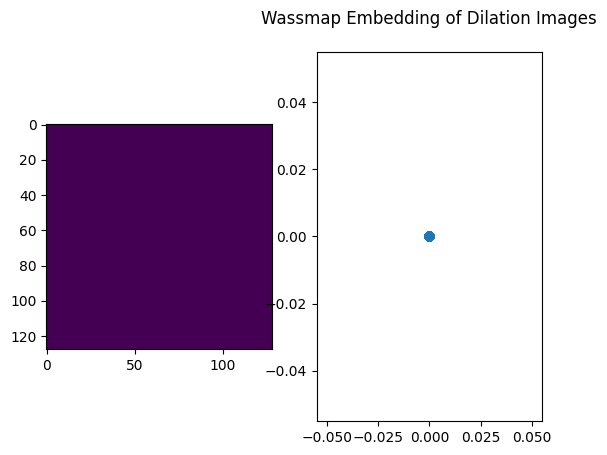

In [45]:
# Compute Wasserstein square distance matrix
squared = True
Wass_distance = Wasserstein_Matrix(dil_images_vox,squared=squared)

# Compute and display Wassmap embedding
#WassEmbedding = man.MDS(n_components=2,metric=True,dissimilarity='precomputed',eps=1e-4).fit_transform(Wass_distance)
WassEmbedding = MDS(Wass_distance,squared=squared)
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.imshow(Wass_distance)
ax2.set_title("Wassmap Embedding of Dilation Images",pad=20)
ax2.scatter(WassEmbedding[:,0],WassEmbedding[:,1])
#plt.savefig('figures/DilationWassmapEmbedding.pdf')
plt.show()

/var/folders/2x/m3nyg7x50mzg_7wsnzcm7hxr0000gn/T/ipykernel_80421/3781674727.py:6: RuntimeWarning: invalid value encountered in divide
  geo_distance_scaled = geo_distance / max_distance


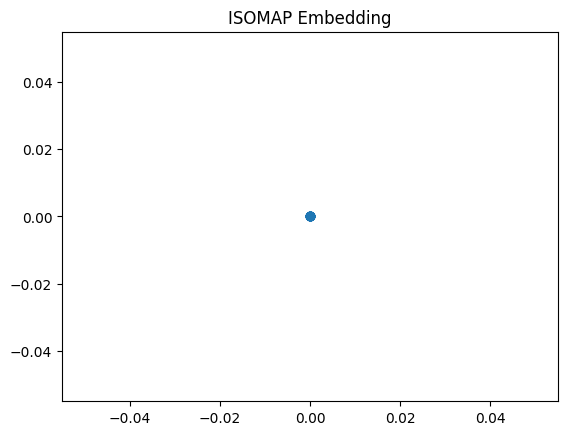

In [49]:
import scipy.linalg as la

# Scale the distance matrix to avoid overflow
max_distance = np.nanmax(geo_distance)
if max_distance > 0:
    geo_distance_scaled = geo_distance / max_distance
else:
    geo_distance_scaled = geo_distance

# Replace NaNs and infinities
geo_distance_clean = np.nan_to_num(geo_distance_scaled)

# Ensure the matrix is symmetric
geo_distance_clean = (geo_distance_clean + geo_distance_clean.T) / 2

# Apply a small constant to the diagonal if necessary
np.fill_diagonal(geo_distance_clean, 0)

# Apply MDS
try:
    EucEmbedding = MDS(geo_distance_clean, squared=True)
    fig, ax3 = plt.subplots()
    ax3.scatter(EucEmbedding[:,0], EucEmbedding[:,1])
    ax3.set_title("ISOMAP Embedding")
    plt.show()
except np.linalg.LinAlgError as e:
    print("Error in MDS:", e)

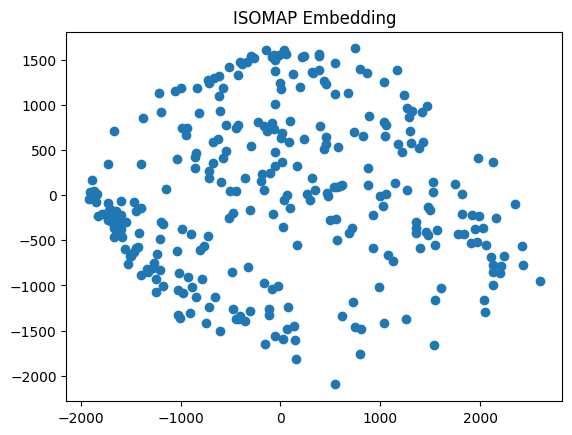

In [50]:
# Compute the geodesic distance matrix
EucEmbedding_trans = MDS(geo_distance_trans,squared=True)
#EucEmbedding = MDS(euc_matrix,squared=True)
fig, ax3 = plt.subplots()
ax3.scatter(EucEmbedding_trans[:,0], EucEmbedding_trans[:,1])
ax3.set_title("ISOMAP Embedding")
plt.show()

(300, 2)


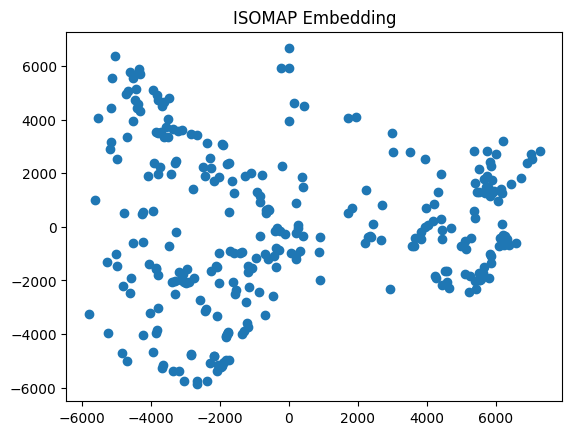

In [56]:
temp = np.reshape(image_tensor.T,[image_tensor.shape[-1],image_tensor.shape[0]**2])
trans_embedded_isomap = man.Isomap(n_neighbors=7,n_components=2,metric='euclidean').fit_transform(temp)
print(trans_embedded_isomap.shape)
fig, ax = plt.subplots()
scatter_x = trans_embedded_isomap[:,0]
scatter_y = trans_embedded_isomap[:,1]
# for g in np.unique(small_mnist_labels):
#     i = np.where(small_mnist_labels == g)
ax.scatter(scatter_x, scatter_y)
ax.set_title("ISOMAP Embedding")
#plt.savefig('/content/drive/My Drive/Colab Notebooks/figures/TranslationISOMAPEmbedding.pdf',bbox_inches='tight')
#ax.legend()
plt.show()

In [57]:
print(dil_images_vox.shape)
print(128*128)
temp = np.reshape(dil_images_vox,[dil_images_vox.shape[-1],dil_images_vox.shape[0]**2])
print(temp.shape)

(128, 128, 16)
16384
(16, 16384)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(16, 2)


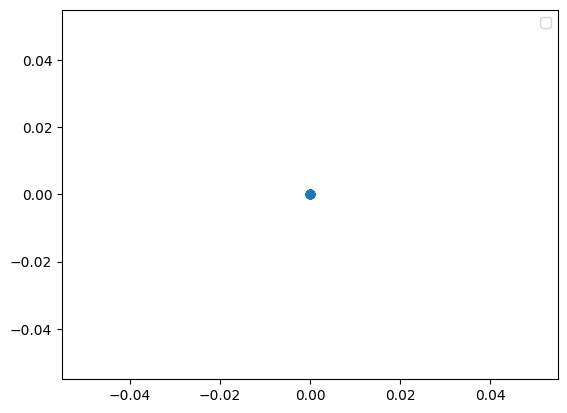

In [58]:
temp = np.reshape(dil_images_vox.T,[dil_images_vox.shape[-1],dil_images_vox.shape[0]**2])
dil_embedded_isomap = man.Isomap(n_neighbors=14,n_components=2,metric='euclidean',).fit_transform(temp)
print(dil_embedded_isomap.shape)
fig, ax = plt.subplots()
scatter_x = dil_embedded_isomap[:,0]
scatter_y = dil_embedded_isomap[:,1]
# for g in np.unique(small_mnist_labels):
#     i = np.where(small_mnist_labels == g)
ax.scatter(scatter_x, scatter_y)
ax.legend()
plt.show()

In [60]:
def translation(object, translate_direction):
    object_array = np.array(object)
    direction_array = np.array(translate_direction)
    image = [x + direction_array for x in object_array]
    return np.array(image)

In [65]:
def in_circle(center, radius, point):
    if (point[1]-center[1])**2+(point[0]-center[0])**2<=radius**2:
        return True
    else:
        return False

In [66]:
def generate_circle(center, radius, samples=100):
    x = np.linspace(center[0]-radius, center[0]+radius, num=samples)
    y = np.linspace(center[1]-radius, center[1]+radius, num=samples)
    xy_0 = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])
    xy = []
    for point in xy_0:
        if in_circle(center,radius,point):
            xy.append(point)
    return np.array(xy)

In [68]:
# Generate translation set
num_translates = 4
num_samp = num_translates**2
x = np.linspace(-1,1,num=num_translates)
y = np.linspace(-1,1,num=num_translates)
xx,yy = np.meshgrid(x,y) #num_translates x num_translates matrices; each xx,yy entry is a translation vector
xx = np.reshape(xx,(num_translates**2,1))
yy = np.reshape(yy,(num_translates**2,1))
translates = np.zeros((num_translates**2,2))
for i in range(len(xx)):
    translates[i,0] = xx[i]
    translates[i,1] = yy[i]


In [69]:
num_samplepoints = 32
circ = generate_circle([0,0],1,samples=num_samplepoints)

# Generate translation images and image tensor
trans_images = []
for i in range(num_translates**2):
    img = np.concatenate((translation(circ,[translates[i,0],translates[i,1]]),np.ones((circ.shape[0],1))/circ.shape[0]),axis=1)
    trans_images.append(img)

# Generate voxel images (for ISOmap)
nvox = 128
nxg = nvox
nyg = nvox

xg = np.linspace(-2,2,nxg)
yg = np.linspace(-2,2,nyg)
xxg,yyg = np.meshgrid(xg,yg,indexing='ij')
grid = np.stack((xxg,yyg))
trans_images_vox = np.zeros((nvox,nvox,num_translates**2))
for i in range(num_translates**2):
    pc = trans_images[i]
    trans_images_vox[:,:,i] = pointcloud_to_vox(pc,grid)